[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Using Colab cache for faster access to the 'sms-spam-collection-dataset' dataset.
Path to dataset files: /kaggle/input/sms-spam-collection-dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None
label
ham     4825
spam     747
Name: count, dtype: int64

--- HAM ---


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top words: [(('u',), 979), (('gt',), 318), (('lt',), 316), (('get',), 301), (('go',), 248), (('ok',), 245), (('got',), 242), (('ur',), 237), (('know',), 236), (('like',), 231)]
Top bigrams: [(('lt', 'gt'), 276), (('gon', 'na'), 58), (('call', 'later'), 50), (('let', 'know'), 39), (('sorry', 'call'), 38), (('r', 'u'), 37), (('u', 'r'), 35), (('good', 'morning'), 31), (('take', 'care'), 31), (('u', 'wan'), 29)]
Top trigrams: [(('sorry', 'call', 'later'), 38), (('lt', 'decimal', 'gt'), 23), (('gt', 'lt', 'gt'), 18), (('happy', 'new', 'year'), 18), (('lt', 'gt', 'lt'), 16), (('like', 'lt', 'gt'), 14), (('pls', 'send', 'message'), 13), (('cant', 'pick', 'phone'), 12), (('pick', 'phone', 'right'), 12), (('phone', 'right', 'pls'), 12)]

--- SPAM ---
Top words: [(('call',), 346), (('free',), 219), (('txt',), 156), (('ur',), 144), (('u',), 141), (('mobile',), 123), (('text',), 121), (('stop',), 114), (('claim',), 113), (('reply',), 104)]
Top bigrams: [(('please', 'call'), 45), (('po', 'box'), 2

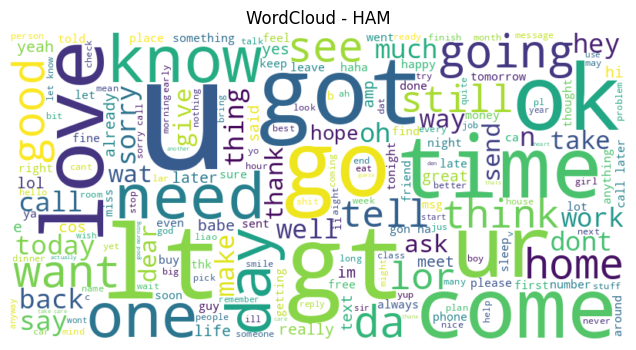

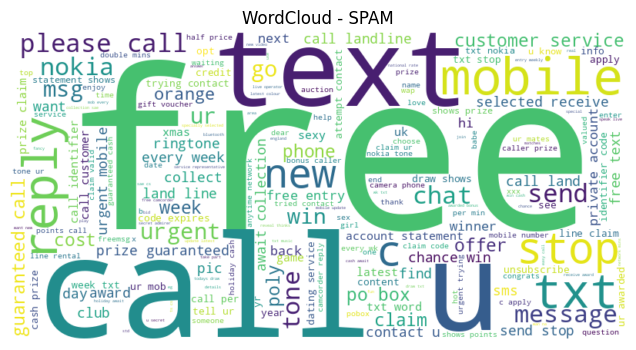

BoW Logistic Regression F1-score: 0.9097
BoW Naive Bayes F1-score: 0.9371
TF-IDF Logistic Regression F1-score: 0.8647
TF-IDF Naive Bayes F1-score: 0.8372


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


TF-IDF + Preprocessing Logistic Regression F1-score: 0.7778
TF-IDF + Preprocessing Naive Bayes F1-score: 0.8593

Final F1-score Comparison:
                          BoW    TF-IDF  TF-IDF + Preprocessing
Logistic Regression  0.909747  0.864662                0.777778
Naive Bayes          0.937063  0.837209                0.859316


In [3]:
# =========================
# STEP 1: Download dataset
# =========================
import kagglehub
import nltk
nltk.download('punkt_tab')
path = kagglehub.dataset_download("uciml/sms-spam-collection-dataset")
print("Path to dataset files:", path)

import pandas as pd

# Load the file (usually named 'spam.csv')
df = pd.read_csv(path + "/spam.csv", encoding="latin-1")
df = df[['v1', 'v2']]  # Keep only needed columns
df.columns = ['label', 'text']
df.head()

# =========================
# STEP 2: Basic info
# =========================
print(df.info())
print(df['label'].value_counts())

# =========================
# STEP 3: EDA
# =========================
import nltk
from nltk.corpus import stopwords
from collections import Counter
from nltk.util import ngrams
import matplotlib.pyplot as plt
from wordcloud import WordCloud

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_for_eda(text):
    tokens = nltk.word_tokenize(text.lower())
    return [t for t in tokens if t.isalpha() and t not in stop_words]

def top_n_grams(corpus, n=1, top_k=10):
    tokens = []
    for text in corpus:
        tokens.extend(preprocess_for_eda(text))
    n_grams = list(ngrams(tokens, n))
    counter = Counter(n_grams)
    return counter.most_common(top_k)

# Most frequent words, bigrams, trigrams per class
for label in df['label'].unique():
    subset = df[df['label'] == label]['text']
    print(f"\n--- {label.upper()} ---")
    print("Top words:", top_n_grams(subset, n=1))
    print("Top bigrams:", top_n_grams(subset, n=2))
    print("Top trigrams:", top_n_grams(subset, n=3))

# WordCloud per class
for label in df['label'].unique():
    subset = df[df['label'] == label]['text']
    words = ' '.join([' '.join(preprocess_for_eda(text)) for text in subset])
    wc = WordCloud(width=800, height=400, background_color='white').generate(words)
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud - {label.upper()}")
    plt.show()

# =========================
# STEP 4: Bag-of-Words
# =========================
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

vectorizer_bow = CountVectorizer()
X_train_bow = vectorizer_bow.fit_transform(X_train)
X_test_bow = vectorizer_bow.transform(X_test)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB()
}

scores_bow = {}
for name, model in models.items():
    model.fit(X_train_bow, y_train)
    preds = model.predict(X_test_bow)
    score = f1_score(y_test, preds, pos_label="spam")
    scores_bow[name] = score
    print(f"BoW {name} F1-score: {score:.4f}")

# =========================
# STEP 5: TF-IDF
# =========================
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tfidf = TfidfVectorizer()
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

scores_tfidf = {}
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    preds = model.predict(X_test_tfidf)
    score = f1_score(y_test, preds, pos_label="spam")
    scores_tfidf[name] = score
    print(f"TF-IDF {name} F1-score: {score:.4f}")

# =========================
# STEP 6: TF-IDF + Preprocessing
# =========================
import re
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def custom_preprocess(text):
    text = text.lower()
    text = re.sub(r'\S+@\S+', '', text)  # remove emails
    text = re.sub(r'http\S+|www\S+', '', text)  # remove urls
    text = re.sub(r'<.*?>', '', text)  # remove html
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]
    return ' '.join(tokens)

df['text_clean'] = df['text'].apply(custom_preprocess)
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(df['text_clean'], df['label'], test_size=0.2, random_state=42)

vectorizer_tfidf_p = TfidfVectorizer()
X_train_tfidf_p = vectorizer_tfidf_p.fit_transform(X_train_p)
X_test_tfidf_p = vectorizer_tfidf_p.transform(X_test_p)

scores_tfidf_p = {}
for name, model in models.items():
    model.fit(X_train_tfidf_p, y_train_p)
    preds = model.predict(X_test_tfidf_p)
    score = f1_score(y_test_p, preds, pos_label="spam")
    scores_tfidf_p[name] = score
    print(f"TF-IDF + Preprocessing {name} F1-score: {score:.4f}")

# =========================
# STEP 7: Final comparison
# =========================
results_df = pd.DataFrame({
    "BoW": scores_bow,
    "TF-IDF": scores_tfidf,
    "TF-IDF + Preprocessing": scores_tfidf_p
})
print("\nFinal F1-score Comparison:")
print(results_df)
